<a href="https://colab.research.google.com/github/NkosikhonaD/experiements/blob/master/Nyla_OnlinePairMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# -------- imports for sampler ---------------------#
import numpy as np
from PIL import Image



from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler
#-------- imports for Loss Functions classes---------#
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.optim import lr_scheduler

from itertools import combinations


#------------------ other imports 
import random
import torchvision.datasets as dset 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.utils
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from google.colab import drive
plt.ion()

drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
class SiameseNetworkDataset(Dataset):
  def __init__(self,imageFolderDataset,transform=None,should_invert=True):
    self.imageFolderDataset = imageFolderDataset
    self.should_invert = should_invert
    self.transform=transform
  
  def __getitem__(self,index):
    img0_tuple = random.choice(self.imageFolderDataset.imgs)
    
    #randomise getting one class.
    should_get_same_class = random.randint(0,1)
    
    if should_get_same_class:
      while True:
        img1_tuple =random.choice(self.imageFolderDataset.imgs)
        if img0_tuple[1] == img1_tuple[1]:
          break
    else:
      while True:
        img1_tuple =random.choice(self.imageFolderDataset.imgs)
        if img0_tuple[1] != img1_tuple[1]:
          break
    
    img0 =Image.open(img0_tuple[0])
    img1 =Image.open(img1_tuple[0])
    
    #img0 = img0.convert("L")
    #img1 = img1.convert("L")
    
    if self.should_invert:
      img0 =PIL.ImageOps.invert(img0)
      img1 =PIL.ImageOps.invert(img1)
    if self.transform is not None:
      img0 = self.transform(img0)
      img1 = self.transform(img1)
      
    return img0, img1,torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
  
  def __len__(self):
    return len(self.imageFolderDataset.imgs)

In [0]:
class BalancedBatchSampler(BatchSampler):
  def __init__(self,labels,n_classes, n_samples):
    self.labels = labels # which labels are these ? names or 0, 1 incase of contrastive ?
    self.label_set = list(set(self.labels.numpy()))
    self.label_to_indices ={label:np.where(self.labels.numpy()==label)[0] for label in self.labels_set}
    
    for l in self.labels_set:
      np.random.shuffle(self.label_to_indices[1]) 
    self.used_label_indices_count = {label: 0 for label in self.labels_set}
    self.count = 0
    self.n_class = n_classes
    self.n_samples = n_samples
    self.n_dataset=len(self,labels)
    self.batch_size = self.n_samples* self.n_classes

    def __iter__(self):
      self.count = 0
      while self.count+self.batch_size < self.n_dataset:
        classes = np.random.choice(self.labels_set,self.n_class,replace= False)
        indices = []

        for class_ in classes:
          indices.extend(self.label_to_indices[class_][self.used_label_indices_count[class_]:self.used_label_indices_count[class_]+self.n_samples])
          self.used_label_indices_count[class_]+=self.n_samples
          if self.used_label_indices_count[class_]+self.n_samples>len(self.label_to_indices[calss_]):
            np.random.shuffle(self.label_to_indices[class_])
            self.used_label_indices_count[class_] =0
        yield indices
        self.count+=self.n_classes*self.n_samples
      
      def __len__(self):
        return self.n_dataset // self.batch_size




In [0]:
class OnlineContrastiveLoss(nn.Module):

  def __init__(self,margin,pair_selector):
    super(OnlineContrastiveLoss,self).__init__()
    self.margin = margin
    self.pair_selector =  pair_selector

  def forward(self, embeddings, target):
    positive_pairs,negative_pairs = self.pair_selector.get_parts(embeddings,target)
    if embeddings.is_cuda:
      positive_pairs = positive_pairs.cuda()
      negative_pairs = negative_pairs.cuda()
    positive_loss = (embeddings[positive_pairs[:,0]]- embeddings[positive_pairs[:,1]]).pow(2).sum(1)
    negative_loss = F.relu(self.margin -(embeddings[negative_pairs[:,0]]- embeddings[negative_pairs[:,1]]).pow(2).sum(1).sqrt()).pow(2)
    loss = torch.cat(positive_loss,negative_loss,dim=0)
    return loss.mean()



In [0]:
def pdist(vectors):
  distance_matrix= -2*vectors.mm(torch.t(vectors))+ vectors.pow(2).sum(dim=1).view(1,-1)+vectors.pow(2).sum(dim=1).view(-1,1)
  return distance_matrix

def hardest_negative(loss_values):
  hard_negative=np.argmax(loss_values)
  return hard_negative if loss_values[hard_negative]>0 else None

def random_hard_negative(loss_values):
  hard_negatives = np.where(loss_values>0)[0]
  return np.random.choice(hard_negatives) if len(hard_negatives)>0 else None

def semihard_negative(loss_values,margin):
  semihard_negatives = np.where(np.logical_and(loss_values < margin,loss_values > 0))[0]
  return np.random.choice(semihard_negatives) if len(semihard_negatives)>0 else None


  
  


In [0]:
class PairSelector:
  def __init__(self):
    pass
  def get_pairs(self,embeddings, labels):
    raise NotImplementedError

In [0]:
class HardNegativePairSelector(PairSelector):
  def __init__(self, cpu= True):
    super(HardNegativePairSelector,self).__init__()
    self.cpu = cpu
  def get_pairs(self,embeddings, labels):
    if self.cpu:
      embeddings = embeddings.cpu()
    distance_matrix = pdist(embeddings)
    labels = labels.cpu().data.numpy()

    all_pairs = np.array(list(combinations(range(len(labels)),2)))
    all_pairs = torch.LongTensor(all_pairs)

    positive_pairs = all_pairs[(labels[all_pairs[:,0]]==labels[all_pairs[:,1]]).nonzero()]
    negative_pairs = all_pairs[(labels[all_pairs[:,0]]!=labels[all_pairs[:,1]]).nonzero()]

    negative_distances = distance_matrix[negative_pairs[:,0],negative_pairs[:,1]]
    negative_distances = negative_distances.cpu.data.numpy()

    top_negatives = np.argpartition(negative_distances,len(positive_pairs))[:len(positive_pairs)]

    top_negative_pairs = negative_pairs[torch.LongTensor(top_negatives)] 

    return positive_pairs, top_negative_pairs




In [0]:
class Metric:
  def __init__(self):
    pass
  def __call__(self,outputs,target, loss):
    raise NotImplementedError
  def reset(self):
    raise NotImplementedError
  def value(self):
    raise NotImplementedError
  def name(self):
    raise NotImplementedError   

In [0]:
class AccummulatedAccuracyMetric(Metric):
  def __init__(self):
    self.correct = 0
    self.total = 0
  def __call__(self,outputs,target, loss):
    pred = outputs[0].data.max(1,keepdim=True)[1]
    self.corect+=pred.eq(target[0].data.view_as(pred)).cpu().sum()
    self.total+=target[0].size(0)
    return value()
  def reset(self):
    self.correct = 0
    self.total = 0
  def value(self):
    return 100*float(self.correct)/self.total
  def name(self):
    return 'Accuracy'


In [0]:
def train_epoch():
  for metric in metrics :
    metric.reset()
  model.train()
  losses = []
  total_loss = 0

  for batch_idx, (data, target) in enumerate(train_loader):
    target = target if len(target) >0 else None
    if not type(data) in (tuple,list):
      data = (data,)
    if cuda:
      data = tuple(d.cuda() for d in data)
      if target is not None:
        target = target.cuda()
    optimizer.zero_grad()
    outputs= model(*data) # Note this might be problematic for our data N,C,H , W

    if type(outputs) not in (tuple,list):
      outputs = (outputs,)
    loss_inputs = outputs
    if target is not None:
      target = (target,)
      loss_inputs+=target
    loss_outputs = loss_fn(*loss_inputs)

    loss = loss_outputs[0] if type(loss_outputs) in (tuple,list) else loss_outputs
    losses.append(loss.item())

    total_loss+=loss.item()
    loss.backward()
    optimser.step()

    for metric in metrics:
      metric(outputs,target, loss_outputs)
    
    if batch_idx%log_interval==0:
      message = 'Train: [{}/{}({:0f}%)]\tLoss: {:6f}'.format(batch_idx*len(data[0]),len(train_loader.datase),100.*batch_idx/len(train_loader),np.mean(losses))
      for metric in metrics:
        message+='\t{}: {}'.format(metric.name(),metric.value())
      print(message)
      losses =[]

  total_loss/=(batch_idx+1)
  return total_loss, metrics
  





In [0]:
def test_epoch(val_loader,model,loss_fn,cuda,metrics):
  with torch.no_grad():
    for metric in metrics:
      metric.reset()
    model.eval()
    val_loss = 0
    for batch_idx , (data,target) in enumerate(val_loader):
      target = target if len(target)> 0 else None
      if not type (data) in (tuple, list):
        data = (data,)
      if cuda:
        data = tuple(d.cuda() for d in data)
        if target is not None: 
            target = target.cuda()

      outputs = model(*data)
      if type(outputs) not in (tuple,list):
        outputs = (outputs,)
      loss_inputs = outputs

      if target is not None:
        target = (target,)
        loss_inputs+=target
      loss_outputs =loss_fn(*loss_inputs)
      loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
      val_loss+=loss.item()

      for metric in metrics: 
        metrics(outputs, target, loss_outputs)
  
  return val_loss,metrics
    

In [0]:
def fit(train_loader, valPloader, model, loss_fn,optimezer,scheduler,n_epochs,cuda,log_interval,metrics=[],start_epoch=0):
  for epoch in range(0,start_epoch):
    schedular.step()
  
  for epoch in range(start_epoch,n_epochs):
    schedular.step()
    #Train
    train_loss, metrics = train_epoch(train_loader,model,loss_fn,optimizer,cuda,log_interval,metrics)
    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch+1,n_epochs,train_loss)
    for metric in metrics:
      message+='\t{}: {}'.format(metric.name(),metric.value())
    val_loss,metrics = test_epoch(val_loader,model, loss_fn,cuda, metrics)
    val_loss/=len(val_loader)

    message+='\Epoch: {}/ {}. Validation set: Average loss: {:.4f}'.format(epoch+1,n_epoch,val_loss)
    for metric in metrics:
      message +='\t{}: {}'.format(metric.name(),metric.value())
    print(message)

In [0]:
def imshow(img,text=None,should_save=False):
  npimg = img.numpy()
  plt.axis("off")
  if text:
    plt.text(75, 8,text,style='italic',fontweight='bold',bbox={'facecolor':'white','alpha':0.8,'pad':10})
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()
def show_plot(iteration,loss):
  plt.plot(iteration,loss)
  plt.show()

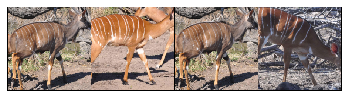

<built-in method numpy of Tensor object at 0x7fe750c628b8>


In [34]:
folder_dataset = dset.ImageFolder(root="/content/drive/My Drive/Nyla_Data/img/train")
siamese_dataset=SiameseNetworkDataset(imageFolderDataset=folder_dataset,transform=transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor()]),should_invert=False)

vis_dataloader = DataLoader(siamese_dataset,shuffle=True,num_workers=2,batch_size=2)
dataiter = iter(vis_dataloader)

example_batch=next(dataiter)
concatenated=torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy)

train_dataloader = DataLoader(siamese_dataset,shuffle=True,num_workers =4,batch_size=6)



In [0]:
train_dataloader = DataLoader(siamese_dataset,shuffle=True,num_workers =4,batch_size=64)


In [0]:
folder_dataset_test = dset.ImageFolder(root="/content/drive/My Drive/Nyla_Data/img/test")
siamese_dataset=SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,transform=transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),should_invert=False)
test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=False)

In [0]:


margin = 1.
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc =nn.Linear(num_ftrs,128)

pair_selector = HardNegativePairSelector()

model = model.cuda()

loss_fn = OnlineContrastiveLoss(margin,pair_selector)
lr= 1e-3
optimizer = optim.Adam(model.parameters(),lr =lr)
schedular = lr_scheduler.StepLR(optimizer,8,gamma=0.1,last_epoch=-1)
n_epoch = 20
log_interval =50
